**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Imports and set magics:

In [57]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import minimize_scalar, minimize, fsolve, root_scalar
import sympy as sm
from sympy import Symbol
from sympy.solvers import solve
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sm.init_printing(use_unicode=True)

# Autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

In [58]:
# Defining baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1/(2*16**2)
w = 1.0
tau = 0.30

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We verify this by using the Lagrangian method. We begin by defining the Lagrangian function:
$$\mathcal{L}(C,G,L,\lambda)=\ln(C^{\alpha}G^{1-\alpha})-\nu\frac{L^{2}}{2}+\lambda\left[\kappa+(1-\tau)wL-C\right]$$
We find the FOC wrt. $L$ by setting the derivative of the function equal to $0$:
$$\frac{\partial \mathcal{L}}{\partial L} = 0$$
$$\Rightarrow \lambda(1-\tau)w - \nu L = 0$$
$$\Rightarrow \lambda(1-\tau)w  = \nu L$$
$$\Rightarrow L = \frac{\lambda(1-\tau)w}{\nu}$$
Then, we find the expression for $C$:
$$C=\kappa+(1-\tau)wL = \kappa+(1-\tau)w\frac{\lambda(1-\tau)w}{\nu} $$
As $\tilde{w} = (1-\tau)w$, we get:
$$C=\kappa+\tilde{w}L = \kappa+\tilde{w}\frac{\lambda(\tilde{w})}{\nu} $$

$$\Rightarrow \lambda = \frac{\sqrt{\kappa^{2}+4\frac{\alpha G}{\nu}\tilde{w}^2}-\kappa}{2\tilde{w}}$$

Which result in:
$$L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha G}{\nu}\tilde{w}^2}}{2\tilde{w}}$$
Hereby, it is vertified that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha G}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

We use the expression for $L^{\star}(\tilde{w})$ to illustrate how the optimal labor supply choice depends on $w$ for different values of $G$. 

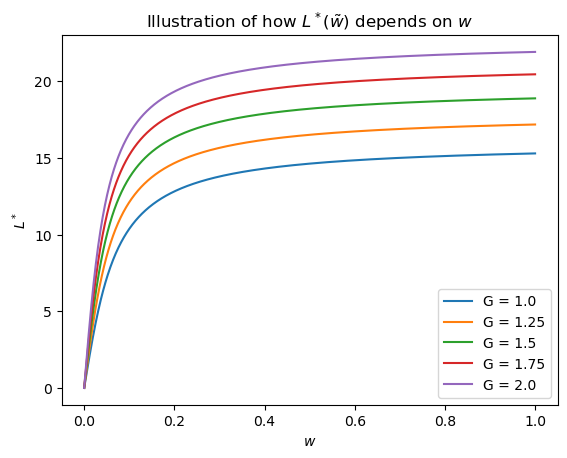

In [59]:
# Defining function for optimal labor supply
def L_star(w, G):
    return (-kappa+np.sqrt(kappa**2+4*alpha*G/(nu)*((1-tau)*w)**2))/(2*((1-tau)*w))

# Defining a range of values for w
w_values = np.linspace(0.000001, 1, 1000)

# Defining values for G
G_values = [1.0, 1.25, 1.5, 1.75, 2.0]

# Plotting L_star as a function of w for different values of G
for G in G_values:
    L_values = L_star(w_values, G)
    plt.plot(w_values, L_values, label='G = {}'.format(G))

# Creating plot
plt.xlabel('$w$')
plt.ylabel('$L^*$')
plt.title('Illustration of how $L^*(\\tilde{w})$ depends on $w$')
plt.legend()
plt.show()

The plot shows that for all values of G, the trend is the same, but a higher value of G results in a higher value for $L^*$.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


We find the labor supply $L^{\star}$, government consumption $G$, and worker utility $V(w,\tau,G)$ for different values of $\tau$. Afterwards, we plot all three variables against $\tau$.

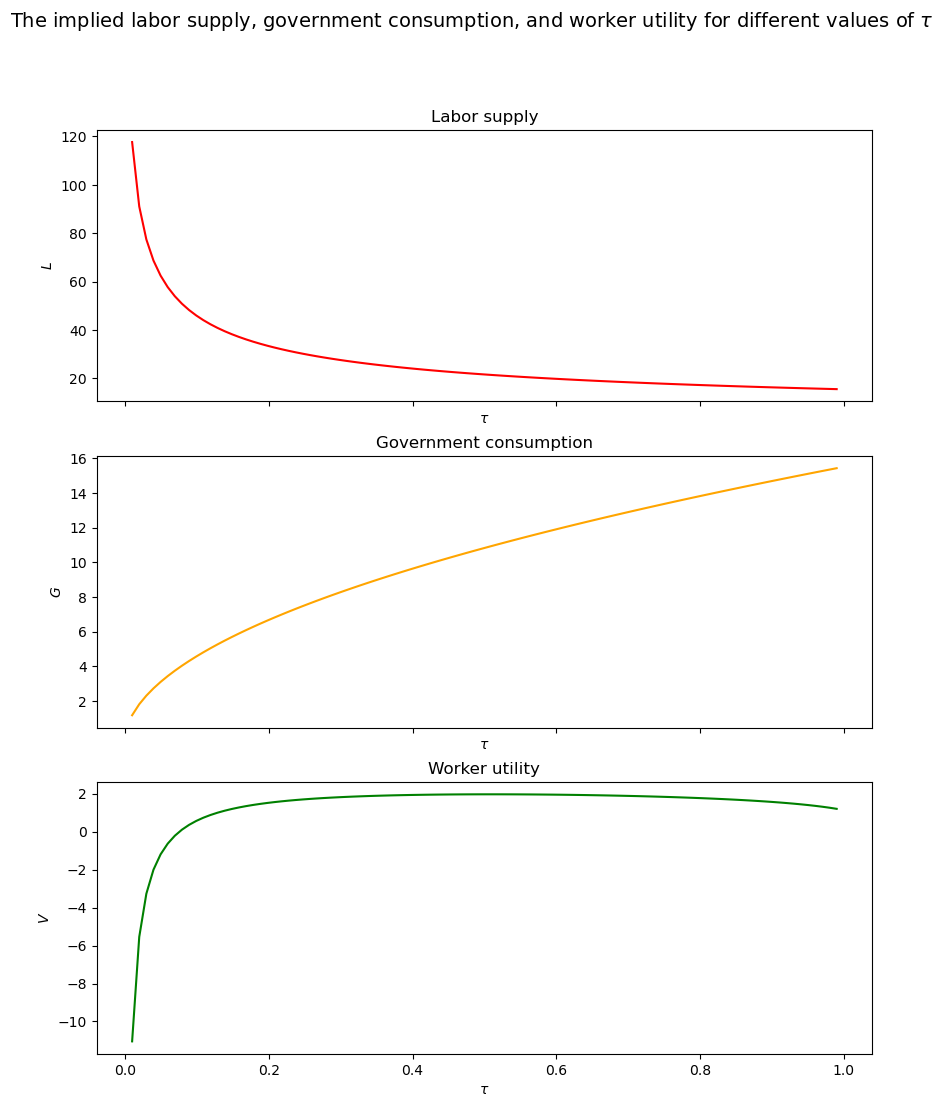

In [60]:
# Defining function for optimal labor supply
def L_star(tau, w):
    return (-kappa+np.sqrt(kappa**2+4*alpha*tau*w**2/nu))/(2*tau*w)

# Defining function for government consumption
def G(tau, w):
    return tau*w*L_star(tau, w)

# Defining function for worker utility
def utility(tau, w):
    L = L_star(tau, w)
    C = kappa+(1-tau)*w*L
    return np.log(C**alpha*G(tau, w)**(1-alpha))-nu*L**2/2

# Defining a range of values for tau
tau_values = np.linspace(0.01, 0.99, 100)

# Calculating optimal labor supply, government consumption, and worker utility for different values of tau
L_values = L_star(tau_values, w)
G_values = G(tau_values, w)
utility_values = utility(tau_values, w)

# Creating plot
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,12))
fig.suptitle('The implied labor supply, government consumption, and worker utility for different values of $\\tau$', fontsize=14)
ax[0].plot(tau_values, L_values, color='red')
ax[0].set_ylabel('$L$')
ax[0].set_xlabel('$\\tau$')
ax[0].set_title('Labor supply')
ax[1].plot(tau_values, G_values, color='orange')
ax[1].set_ylabel('$G$')
ax[1].set_xlabel('$\\tau$')
ax[1].set_title('Government consumption')
ax[2].plot(tau_values, utility_values, color='green')
ax[2].set_ylabel('$V$')
ax[2].set_xlabel('$\\tau$')
ax[2].set_title('Worker utility')
plt.show()

The plot shows that when labor-income tax rate is close to 0, labor supply is high, government consumption is low and worker utility is low. This is because there is incentive to work as the workers keep a bigger part of their wage, but as the tax rate is low, government does not have an income and cannot consume. Worker utility is low, which can be explained by government not being able to provide public goods for the workers. As the labor-income taxe rate increases, labor supply decreases, government consumption increases, and worker utility increases to a certain point, but if the tax rate is too high, worker utility begins to decrease as a too high income-tax reduces incentive to work.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [61]:
# Defining the utility function
def utility(L, tau):
    C = kappa+(1-tau)*w*L
    G = tau*w*L**2
    return np.log(C**alpha*G**(1-alpha))-nu*(L**2)/2

# Defining the objective function
def objective(tau):
    def gov_constraint(L):
        return tau*w*L**2-utility(L, tau)
    res = minimize_scalar(lambda L: -1*utility(L, tau),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return -1*utility(L_star, tau)

# Finding the optimal tax rate
res = minimize_scalar(objective, bounds=(0, 1), method='bounded', options={'disp': 0})
tau_star = res.x
print(f"The socially optimal tax rate is {tau_star:.3f}")

The socially optimal tax rate is 0.521


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma - 1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

We find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using $\tau=0.521$.

In [62]:
# Defining the utility function
def utility(L, C, G, sigma, rho, epsilon):
    return (((alpha*C**((sigma-1)/sigma)+(1-alpha)*G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho)-nu*L**(1+epsilon)/(1+epsilon)

# Defining the objective function
def objective(L, tau, G, sigma, rho, epsilon):
    C = kappa+(1-tau)*w*L
    return -utility(L, C, G, sigma, rho, epsilon)

# Defining the constraint function
def constraint(G, tau, sigma, rho, epsilon):
    def objective_internal(L):
        return -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return G-tau*w*L_star*((1-tau)*w)

# Defining set 1 parameters
sigma = 1.001
rho = 1.001
epsilon = 1.0

# Defining tau
tau = 0.521

# Finding G
def get_G(tau, sigma, rho, epsilon):
    res = minimize(lambda G: constraint(G, tau, sigma, rho, epsilon), 0.5, method='SLSQP', bounds=[(0, None)])
    return res.x[0]

G = get_G(tau, sigma, rho, epsilon)
print(f"The solution to G is {G:.3f} for \u03C4 = {tau:.3f}, \u03C3 = {sigma:.3f}, \u03C1 = {rho:.3f}, \u03B5 = {epsilon:.1f}")

The solution to G is 1.549 for τ = 0.521, σ = 1.001, ρ = 1.001, ε = 1.0


In [63]:
# Defining the utility function
def utility(L, C, G, sigma, rho, epsilon):
    return (((alpha*C**((sigma-1)/sigma)+(1-alpha)*G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho)-nu*L**(1+epsilon)/(1+epsilon)

# Defining the objective function
def objective(L, tau, G, sigma, rho, epsilon):
    C = kappa+(1-tau)*w*L
    return -utility(L, C, G, sigma, rho, epsilon)

# Defining the constraint function
def constraint(G, tau, sigma, rho, epsilon):
    def objective_internal(L):
        return -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return G - tau*w*L_star*((1-tau)*w)

# Defining set 2 parameters
sigma = 1.5
rho = 1.5
epsilon = 1.0

# Defining tau
tau = 0.521


# Finding G
def get_G(tau, sigma, rho, epsilon):
    res = minimize(lambda G: constraint(G, tau, sigma, rho, epsilon), 0.5, method='SLSQP', bounds=[(0, None)])
    return res.x[0]

G = get_G(tau, sigma, rho, epsilon)
print(f"The solution to G is {G:.3f} for \u03C4 = {tau:.3f}, \u03C3 = {sigma:.3f}, \u03C1 = {rho:.3f}, \u03B5 = {epsilon:.1f}")

The solution to G is 0.000 for τ = 0.521, σ = 1.500, ρ = 1.500, ε = 1.0


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [64]:
# Defining the utility function
def utility(L, C, G, sigma, rho, epsilon):
    return (((alpha*C**((sigma-1)/sigma)+(1-alpha)*G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho)-nu*L**(1+epsilon)/(1+epsilon)

# Defining the objective function
def objective(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1-tau)*w*L
    return -utility(L, C, G, sigma, rho, epsilon)

# Defining the constraint function
def constraint(G, tau, sigma, rho, epsilon):
    def objective_internal(L):
        return -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return G - tau*w*L_star*((1-tau)*w)

# Finding G
def get_G(tau, sigma, rho, epsilon):
    res = minimize(lambda G: constraint(G, tau, sigma, rho, epsilon), 0.5, method='SLSQP', bounds=[(0, None)])
    return res.x[0]

# Define the objective function to maximize utility subject to the government budget constraint
def objective_social(tau, G, sigma, rho, epsilon):
    def gov_constraint(L):
        C = kappa+(1-tau)*w*L
        return G-tau*w*L*((1-tau)*w)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return -1*utility(L_star, kappa+(1-tau)*w*L_star, G, sigma, rho, epsilon)

# Defining set 1 parameters
sigma = 1.001
rho = 1.001
epsilon = 1.0

# Finding the socially optimal tax rate
res = minimize_scalar(lambda tau: -1*objective_social(tau, get_G(tau, sigma, rho, epsilon), sigma, rho, epsilon),
                      bounds=(0, 1), method='bounded', options={'disp': 0})
tau_star = res.x

print(f"The socially optimal tax rate is {tau_star:.3f} for \u03C3 = {sigma:.3f}, \u03C1 = {rho:.3f}, \u03B5 = {epsilon:.1f} ")

The socially optimal tax rate is 0.382 for σ = 1.001, ρ = 1.001, ε = 1.0 


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We vertify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$ by using sympy. First we find the derivative of profit wrt. $\ell$. Hereafter we find the equation that maximises profits by putting this equation equal to zero and solve for $\ell$.

In [65]:
# Defining symbols
eta = sm.symbols('eta')
w = sm.symbols('w')
kappa = sm.symbols('kappa')
ell = sm.symbols('ell')
p=sm.symbols('p')
y=sm.symbols('y')

In [66]:
# Differentiation of profit wrt. ell
profit=kappa*ell**(1-eta)-w*ell
diffprofit=profit.diff(ell)
diffprofit

In [67]:
# Ell that optimizes profit
profit=sm.Eq(kappa*(1-eta)*ell**(-eta)-w)
result = sm.solve(profit,ell)
result

This vertifies that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In order to calculate $H$, we choose $K=100$

In [68]:
# Defining parameters
eta = 0.5
w = 1.0
rho = 0.8
sigma_eps = 0.1
iota = 0.1
R = 0.9
T = 120

# Choosing K
K = 100

In [69]:
# Setting initial values
kappa = np.ones(T+1)
ell = np.zeros(T+1)
h_vals = np.zeros(K)


# Simulating shock series and calculating h
for k in range(K):
    eps = np.random.normal(loc=-0.5*sigma_eps**2, scale=sigma_eps, size=T+1)
    for t in range(1, T+1):
        kappa[t] = np.exp(rho*np.log(kappa[t-1]) + eps[t])
    for t in range(T+1):
        ell_new = ((1-eta)*kappa[t]/w)**(1/eta)
        if t == 0:
            adj_cost = 0
        else:
            adj_cost = np.abs(ell_new - ell[t-1])*iota
        pi = kappa[t]*ell_new**(1-eta) - w*ell_new - adj_cost
        h_vals[k] += R**t * pi
        ell[t] = ell_new

H = np.mean(h_vals)
print(f"H = {H:.3f}")

H = 2.496


This means that the *ex ante* expected value of the salon is approximately 2.5.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

We now calcualte $H$ where $\Delta = 0.05$.

In [70]:
# Defining parameters
Delta = 0.05

# Seting initial values
kappa = np.ones(T+1)
ell = np.zeros(T+1)
h_vals = np.zeros(K)

# Simulating shock series and calculating h
for k in range(K):
    eps = np.random.normal(loc=-0.5*sigma_eps**2, scale=sigma_eps, size=T+1)
    for t in range(1, T+1):
        kappa[t] = np.exp(rho*np.log(kappa[t-1]) + eps[t])
    for t in range(T+1):
        ell_new = ((1-eta)*kappa[t]/w)**(1/eta)
        if t == 0:
            adj_cost = 0
        else:
            if np.abs(ell_new - ell[t-1]) > Delta:
                ell_new = np.round(ell_new, 2)
                adj_cost = iota
            else:
                adj_cost = 0
        pi = kappa[t]*ell_new**(1-eta) - w*ell_new - adj_cost
        h_vals[k] += R**t * pi
        ell[t] = ell_new

H = np.mean(h_vals)
print(f"H = {H:.3f}")

H = 2.246


$H$ is now a smaller value, which means that if the policy above was followed with $\Delta = 0.05$, the profitability is not improved.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In order to find the optimal $\Delta$ that maximizes $H$, we try 100 different values of $\Delta$ between 0 and 0.3.

In [71]:
# Setting initial values
kappa = np.ones(T+1)
ell = np.zeros(T+1)
h_vals = np.zeros(K)

# Finding the optimal delta and calculating h
for j, Delta in enumerate(np.linspace(0, 0.3, 100)):
    for k in range(K):
        eps = np.random.normal(loc=-0.5*sigma_eps**2, scale=sigma_eps, size=T+1)
        for t in range(1, T+1):
            kappa[t] = np.exp(rho*np.log(kappa[t-1])+eps[t])
        for t in range(T+1):
            ell_new = ((1-eta)*kappa[t]/w)**(1/eta)
            if t == 0:
                adj_cost = 0
            else:
                if np.abs(ell_new-ell[t-1]) > Delta:
                    ell_new = np.round(ell_new, 2)
                    adj_cost = iota
                else:
                    adj_cost = 0
            pi = kappa[t]*ell_new**(1-eta)-w*ell_new-adj_cost
            h_vals[j] += R**t*pi
            ell[t] = ell_new

optimal_Delta = np.linspace(0, 0.3, 100)[np.argmax(h_vals)]
H_optimal = np.max(h_vals)
print(f"Optimal Delta = {optimal_Delta:.2f}")
print(f"H = {H_optimal:.2f}")

Optimal Delta = 0.30
H = 259.72


This value of $H$ is higher than the values we have previously found, but the optimal value of $\Delta$ is also higher than the $\Delta$ values used in the two previous questions.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



An alternative policy that might improve profitability is to adjust the number of hairdressers employed ($\ell_t$) based on an expected demand shock (forecast).

We use a forecast of $\log \kappa_{t+1}$ based on $\log \kappa_t$ and the estimated parameters for AR(1). Then, we use the forecast to calculate the optimal number of hairdressers employed $\ell_t^{\ast}$, subject to the adjustment cost $\iota$.

This policy uses a 'noisy' forecast of future demand, so it might not always perform better than the other policies, but it has the potential to be more adaptive to changing demand conditions as it takes expected future shocks into account.

In [72]:
# Setting initial values
kappa = np.ones(T+1)
ell = np.zeros(T+1)
h_vals = np.zeros(K)

# Defining forecast
def forecast_kappa(log_kappa_t, eps_t):
    return rho*log_kappa_t-0.5*sigma_eps**2+eps_t

# Finding the optimal delta and calculating h
for j, Delta in enumerate(np.linspace(0, 0.3, 100)):
    for k in range(K):
        eps = np.random.normal(loc=-0.5*sigma_eps**2, scale=sigma_eps, size=T+1)
        for t in range(1, T+1):
            kappa[t] = np.exp(forecast_kappa(np.log(kappa[t-1]), eps[t]))
            ell_new = ((1-eta)*kappa[t]/w)**(1/eta)
            if t == 0:
                adj_cost = 0
            else:
                if np.abs(ell_new-ell[t-1]) > Delta:
                    ell_new = np.round(ell_new, 2)
                    adj_cost = iota
                else:
                    adj_cost = 0
            pi = kappa[t]*ell_new**(1-eta)-w*ell_new-adj_cost
            h_vals[j] += R**t*pi
            ell[t] = ell_new

optimal_Delta = np.linspace(0, 0.3, 100)[np.argmax(h_vals)]
H_optimal = np.max(h_vals)
print(f"Optimal Delta = {optimal_Delta:.2f}")
print(f"H = {H_optimal:.2f}")

Optimal Delta = 0.30
H = 225.61


The results show that this alternative policy leads to a lower $H$ than in question 4 with the original policy. Therefore, we can conclude that adjusting the number of hairdressers employed based on the expected demand shock does not lead to higher profitability.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [73]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

We implement the refined global optimizer with multi-start and illustrate the effective initial guesses. 

In [74]:
# Defining griewank
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

# Defining Global_opt
def global_opt(bounds, tau, K, K_warmup):
    # Best solution and value
    x_best = None
    f_best = np.inf

    # Warm-up iterations without refinement step
    for k in range(K_warmup):
        # Draw random guess within bounds
        x0 = np.random.uniform(bounds[:, 0], bounds[:, 1])

        # Minimizing function with BFGS
        res = minimize(griewank, x0, method="BFGS", tol=tau)

        # New best solution and value
        if res.fun < f_best:
            x_best = res.x
            f_best = res.fun

    # Refinement iterations
    for k in range(K_warmup, K):
        # Drawing random guess within bounds
        xk = np.random.uniform(bounds[:, 0], bounds[:, 1])

        if k == K_warmup:
            x_ref = x_best
        else:
            chi_k = 0.5*2/(1+np.exp((k-K_warmup)/100))

            # Adjusting initial guess
            x_ref = chi_k*xk+(1-chi_k)*x_best

        # Minimizing function with BFGS
        res = minimize(griewank, x_ref, method="BFGS", tol=tau)

        # New best solution if improved 
        if res.fun < f_best:
            x_best = res.x
            f_best = res.fun

        # Printing
        print(f"iteration {k}: f_best = {f_best:.8f}")
        print(f"x_eff  = {x_ref},\n")

    return x_best, f_best

Global_opt has three arguments: $1.$ lower and upper bounds for the variables $x_1$ and $x_2$, $2.$ tau is the tolerance, and $3.$ K is the maximum number of iterations (including warm-up iterations) and K_warmup is the number of warm-up iterations. The best solution found during the warm-up iterations is stored in x_best and f_best. 

The refinement iterations are done from K_warmup up to K. In each iteration, a new point (xk) is drawn uniformly within the bounds. x_best is used as the reference point x_ref if k==K_warmup, otherwise a parameter chi_k is used and x_ref is then used as the initial guess. The best solution is stored in x_best and f_best if it is improved compared to the previous best solution 

Finally, the effective initial guess is either: $1.$ the best point found during the warm-up, or $2.$ a point that is a combination of the new point and the best point.


Based on the chosen settings, we get:

In [75]:
# Defining settings
bounds = np.array([[-600, 600], [-600, 600]])
tau = 1e-8
K_warmup = 10
K = 1000

# Running iterations
x_best, f_best = global_opt(bounds, tau, K, K_warmup)

iteration 10: f_best = 6.16283096
x_eff  = [-153.86101479  -31.0690167 ],

iteration 11: f_best = 3.34387638
x_eff  = [-104.76585122   46.03875945],

iteration 12: f_best = 3.34387638
x_eff  = [ 205.55524001 -145.08767865],

iteration 13: f_best = 3.34387638
x_eff  = [ -15.5977376  -231.30497595],

iteration 14: f_best = 3.34387638
x_eff  = [-307.65651848 -161.36252703],

iteration 15: f_best = 3.34387638
x_eff  = [-276.86843208  181.88060966],

iteration 16: f_best = 3.34387638
x_eff  = [-160.98640257 -173.90409438],

iteration 17: f_best = 3.34387638
x_eff  = [ 131.50579397 -159.94731632],

iteration 18: f_best = 3.34387638
x_eff  = [-316.74097448  115.54091416],

iteration 19: f_best = 3.34387638
x_eff  = [ 26.76745313 294.15207501],

iteration 20: f_best = 3.34387638
x_eff  = [149.20464986 214.53378423],

iteration 21: f_best = 2.37383230
x_eff  = [ 29.97038427 -91.77792335],

iteration 22: f_best = 2.37383230
x_eff  = [ 51.4468618  175.53903871],

iteration 23: f_best = 0.95399049

We plot the effective initial guesses for the iterations:

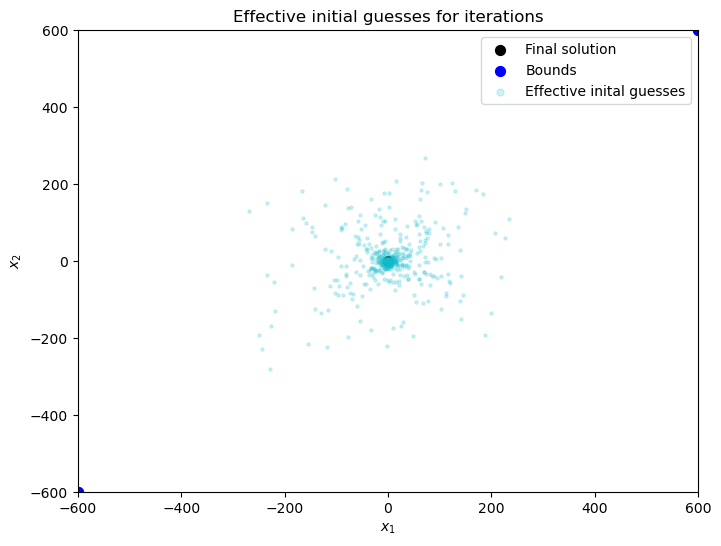

In [76]:
# Plotting effective initial guesses
plt.figure(figsize=(8, 6))
plt.scatter(x_best[0], x_best[1], color="black", s=50, label="Final solution")
plt.scatter(bounds[:, 0], bounds[:, 0], color="blue", s=50, label="Bounds")
plt.scatter(bounds[:, 1], bounds[:, 1], color="blue", s=50)

# Iterations
for k in range(K):
    if k < K_warmup:
        x_ref = x_best
    else:
        chi_k = 0.5*2/(1+np.exp((k-K_warmup)/100))

        # Adjusting initial guess
        xk = np.random.uniform(bounds[:, 0], bounds[:, 1])
        x_ref = chi_k*xk+(1-chi_k)*x_best

    plt.scatter(x_ref[0], x_ref[1], color="#17becf", 
                alpha=0.2, s=5)
plt.scatter(-1000,-1000, alpha=0.2, s=25, color="#17becf", label="Effective inital guesses")

# More plotting
plt.legend()
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Effective initial guesses for iterations")
plt.show()

The plot shows the bounds, the final solution, and the effective initial guesses for iterations. The effective initial guesses are scattered around the final solution around (0,0). 

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

We now compare $\underline{K}=10$ to $\underline{K}=100$ to see which one converges faster.

In [77]:
# Defining settings
bounds = np.array([[-600, 600], [-600, 600]])
tau = 1e-8
K_warmup1 = 10
K_warmup2 = 100
K = 1000

In [78]:
# Running K_warmup1 = 10
x_best1, f_best1 = global_opt(bounds, tau, K, K_warmup1)
print(f"Best value for K_warmup={K_warmup1}: {f_best1:.8f}")

iteration 10: f_best = 13.57794242
x_eff  = [-94.20011653 213.04427767],

iteration 11: f_best = 13.57794242
x_eff  = [231.93207448 -20.32213949],

iteration 12: f_best = 13.57794242
x_eff  = [-68.6060269  347.50235884],

iteration 13: f_best = 9.30829235
x_eff  = [ -76.10434748 -180.79669257],

iteration 14: f_best = 9.30829235
x_eff  = [-206.8271322   46.7241544],

iteration 15: f_best = 1.42719893
x_eff  = [-2.99581116 74.07976289],

iteration 16: f_best = 1.42719893
x_eff  = [-172.81756034  295.06508059],

iteration 17: f_best = 1.42719893
x_eff  = [ 80.60425684 193.51147347],

iteration 18: f_best = 1.42719893
x_eff  = [ -95.58816464 -129.44776401],

iteration 19: f_best = 1.42719893
x_eff  = [ 53.44593511 170.00617517],

iteration 20: f_best = 1.42719893
x_eff  = [-99.12793297 129.73511311],

iteration 21: f_best = 1.42719893
x_eff  = [-117.19867285   98.74426729],

iteration 22: f_best = 1.42719893
x_eff  = [199.73690137 -90.57517556],

iteration 23: f_best = 1.42719893
x_eff  =

In [79]:
# Running K_warmup2 = 100
x_best2, f_best2 = global_opt(bounds, tau, K, K_warmup2)
print(f"Best value for K_warmup={K_warmup2}: {f_best2:.8f}")

iteration 100: f_best = 0.06656436
x_eff  = [ -9.42006771 -13.31533316],

iteration 101: f_best = 0.06656436
x_eff  = [-39.99653065 108.19329577],

iteration 102: f_best = 0.06656436
x_eff  = [164.70973977  31.28828724],

iteration 103: f_best = 0.06656436
x_eff  = [-34.30812652 171.32412263],

iteration 104: f_best = 0.06656436
x_eff  = [-186.74062103 -154.73417692],

iteration 105: f_best = 0.06656436
x_eff  = [  2.42993839 -57.72068793],

iteration 106: f_best = 0.06656436
x_eff  = [-236.54116527 -227.75528122],

iteration 107: f_best = 0.06656436
x_eff  = [236.50961152 162.58975839],

iteration 108: f_best = 0.06656436
x_eff  = [220.44292276 267.29832217],

iteration 109: f_best = 0.06656436
x_eff  = [-89.81656135 249.45288   ],

iteration 110: f_best = 0.06656436
x_eff  = [ 73.41537463 144.98239713],

iteration 111: f_best = 0.06656436
x_eff  = [222.45400779  11.45599186],

iteration 112: f_best = 0.06656436
x_eff  = [-189.32463447 -286.13940607],

iteration 113: f_best = 0.066564

When we run the code three times and look through the iterations each time, we find that:
  
$\underline{K}=10$ converges at iteration 215, iteration 297 and iteration 188 
 
and
 
$\underline{K}=100$ converges at iteration 477, iteration 385 and iteration 407

Based on our observations, we find that $\underline{K}=10$ converges faster compared to $\underline{K}=100$, but they both converge to 0 well before the last iteration.